In [1]:
# import libraries

import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import category_encoders as ce 
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import hyperopt
from scipy.stats import skew, norm
from hyperopt import hp, tpe, fmin, Trials
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings(action="ignore")

plt.style.use('default')

In [2]:
# load data

train_data = pd.read_csv(r'C:\Users\79654\OneDrive\Desktop\Проекты на Kaggle\Разработка\house prices\train.csv')
test_data = pd.read_csv(r'C:\Users\79654\OneDrive\Desktop\Проекты на Kaggle\Разработка\house prices\test.csv')
train_data.columns = train_data.columns.str.replace(' ', '')
test_data.columns = test_data.columns.str.replace(' ', '')

target = train_data['SalePrice']
id = test_data['Id']
train_data = train_data.drop(['SalePrice', 'Id'], axis=1)
test_data = test_data.drop(['Id'], axis=1)

train_test = pd.concat([train_data, test_data], axis=0, sort=False)

In [3]:
# detect NaN values

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

NaN_sum          feat     Perc(%) Usability
TotalBsmtSF         1   TotalBsmtSF    0.068493      Keep
GarageArea          1    GarageArea    0.068493      Keep
GarageCars          1    GarageCars    0.068493      Keep
KitchenQual         1   KitchenQual    0.068493      Keep
Electrical          1    Electrical    0.068493      Keep
BsmtUnfSF           1     BsmtUnfSF    0.068493      Keep
BsmtFinSF2          1    BsmtFinSF2    0.068493      Keep
BsmtFinSF1          1    BsmtFinSF1    0.068493      Keep
SaleType            1      SaleType    0.068493      Keep
Exterior1st         1   Exterior1st    0.068493      Keep
Exterior2nd         1   Exterior2nd    0.068493      Keep
Functional          2    Functional    0.136986      Keep
Utilities           2     Utilities    0.136986      Keep
BsmtHalfBath        2  BsmtHalfBath    0.136986      Keep
BsmtFullBath        2  BsmtFullBath    0.136986      Keep
MSZoning            4      MSZoning    0.273973      Keep
MasVnrArea         23    MasVnrArea    1.575342      Keep
BsmtFinType1       79  BsmtFinType1    5.410959      Keep
BsmtFinType2       80  BsmtFinType2    5.479452      Keep
BsmtQual           81      BsmtQual    5.547945      Keep
BsmtCond           82      BsmtCond    5.616438      Keep
BsmtExposure       82  BsmtExposure    5.616438      Keep
GarageType        157    GarageType   10.753425      Keep
GarageCond        159    GarageCond   10.890411      Keep
GarageQual        159    GarageQual   10.890411      Keep
GarageYrBlt       159   GarageYrBlt   10.890411      Keep
GarageFinish      159  GarageFinish   10.890411      Keep
LotFrontage       486   LotFrontage   33.287671   Discard
FireplaceQu      1420   FireplaceQu   97.260274   Discard
MasVnrType       1766    MasVnrType  120.958904   Discard
Fence            2348         Fence  160.821918   Discard
Alley            2721         Alley  186.369863   Discard
MiscFeature      2814   MiscFeature  192.739726   Discard
PoolQC           2909        PoolQC  199.246575   Discard

In [4]:
# converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# filling categorical NaN 

train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
    # checking the features with NaN remained out

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

0    RL
0    RH
Name: MSZoning, dtype: object
0    65.0
0    80.0
Name: LotFrontage, dtype: float64
0    AllPub
0    AllPub
Name: Utilities, dtype: object
0    BrkFace
0        NaN
Name: MasVnrType, dtype: object
0    196.0
0      0.0
Name: MasVnrArea, dtype: float64
0    706.0
0    468.0
Name: BsmtFinSF1, dtype: float64
0      0.0
0    144.0
Name: BsmtFinSF2, dtype: float64
0    150.0
0    270.0
Name: BsmtUnfSF, dtype: float64
0    856.0
0    882.0
Name: TotalBsmtSF, dtype: float64
0    1.0
0    0.0
Name: BsmtFullBath, dtype: float64
0    0.0
0    0.0
Name: BsmtHalfBath, dtype: float64
0    2003.0
0    1961.0
Name: GarageYrBlt, dtype: float64


In [5]:
# removing the useless variables

useless = ['GarageYrBlt','YearRemodAdd'] 
train_test = train_test.drop(useless, axis = 1)

# imputing with KnnRegressor

def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()
    cols_no_nan = ttn.columns.difference(cols_nan).values

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()] 
        imp_train = ttn.dropna()
        model = KNeighborsRegressor(n_neighbors=5)
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

In [6]:
# feature engineering

train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# fetch all numeric features

numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

In [7]:
# import libraries

from scipy.stats import t, norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [8]:
# import libraries

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostRegressor
from catboost import Pool 
import shap

In [9]:
# split data into training and test sets and normalize target 

train_data = train_test_dummy[0:1460]
test_data = train_test_dummy[1460:]
X = train_data
y = np.log1p(target)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

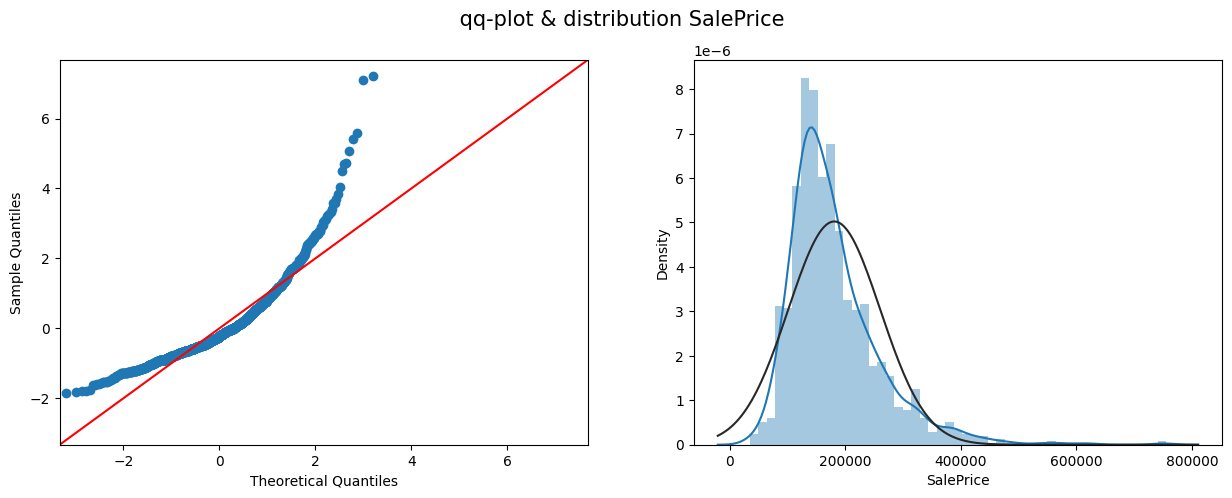

In [10]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

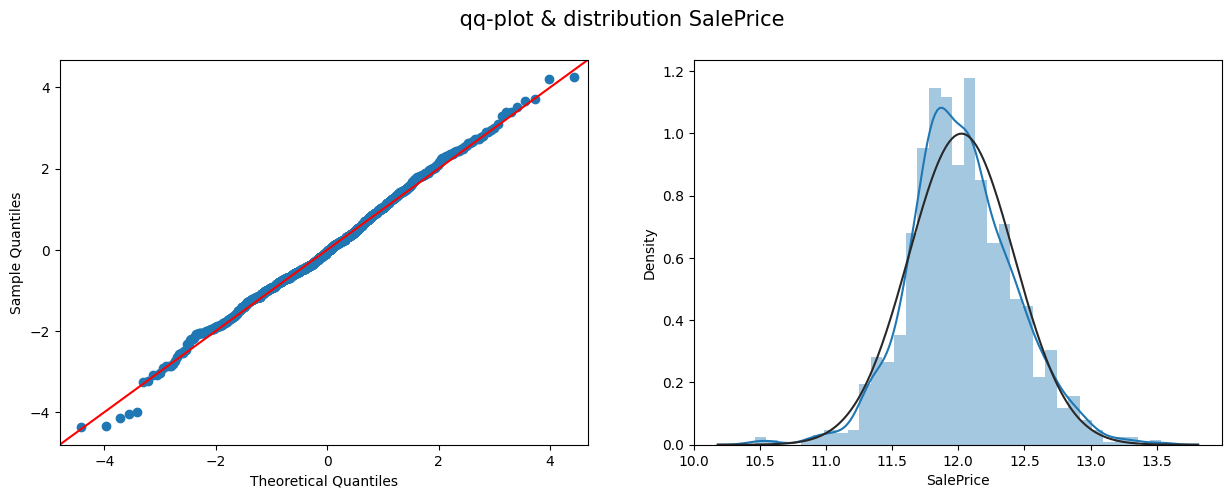

In [11]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(y, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(y, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [12]:
# fit model and evaluate metrics
params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}

cb = CatBoostRegressor(**params)
cb.fit(X_train, y_train,
       eval_set=(X_test, y_test),
       plot=True,
       verbose=0)

y_train_predict = np.expm1(cb.predict(X_train))
y_test_predict = np.expm1(cb.predict(X_test))
print(round(metrics.root_mean_squared_log_error(np.expm1(y_train), y_train_predict), 3))
print(round(metrics.root_mean_squared_log_error(np.expm1(y_test), y_test_predict), 3))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.072
0.108


In [13]:
# feature importance Interactive Plot 

train_pool = Pool(X_train)
test_pool = Pool(X_test)

explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(train_pool)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

In [14]:
# generate final predictions

cb.fit(X, y)
result = cb.predict(test_data)
result = np.expm1(result)

0:	learn: 0.3980461	total: 5.38ms	remaining: 32.3s
200:	learn: 0.2355557	total: 978ms	remaining: 28.2s
400:	learn: 0.1708528	total: 1.8s	remaining: 25.2s
600:	learn: 0.1431749	total: 2.78s	remaining: 25s
800:	learn: 0.1281502	total: 3.79s	remaining: 24.6s
1000:	learn: 0.1188523	total: 4.79s	remaining: 23.9s
1200:	learn: 0.1123501	total: 5.75s	remaining: 23s
1400:	learn: 0.1073871	total: 6.61s	remaining: 21.7s
1600:	learn: 0.1032262	total: 7.48s	remaining: 20.5s
1800:	learn: 0.0995571	total: 8.31s	remaining: 19.4s
2000:	learn: 0.0964134	total: 9.14s	remaining: 18.3s
2200:	learn: 0.0934818	total: 9.88s	remaining: 17.1s
2400:	learn: 0.0908691	total: 10.9s	remaining: 16.3s
2600:	learn: 0.0886012	total: 11.7s	remaining: 15.3s
2800:	learn: 0.0864623	total: 12.7s	remaining: 14.5s
3000:	learn: 0.0844762	total: 13.5s	remaining: 13.5s
3200:	learn: 0.0825793	total: 14.5s	remaining: 12.7s
3400:	learn: 0.0808036	total: 15.5s	remaining: 11.8s
3600:	learn: 0.0791347	total: 16.4s	remaining: 10.9s
3800

In [15]:
# save results to CSV

submission = pd.DataFrame({'Id': id, 'SalePrice': result})
submission.to_csv(r"C:\Users\79654\OneDrive\Desktop\Проекты на Kaggle\Разработка\house prices\submission.csv", index=False)